In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
data_path = "~/movie/data/train"
train_df = pd.read_csv(os.path.join(data_path, "train_ratings.csv")) # 전체 학습 데이터

In [3]:
# 아이템 side information 불러오기
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

In [4]:
# side information을 하나의 아이템 데이터프레임으로 병합
item_df = pd.merge(title_data, year_data, on="item", how="left")
item_df = pd.merge(item_df, director_data, on="item", how="left")
item_df = pd.merge(item_df, writer_data, on="item", how="left")
item_df = pd.merge(item_df, genre_data, on="item", how="left")

item_df

,item,title,year,director,writer,genre
0,318,"Shawshank Redemption, The (1994)",1994.0,nm0001104,nm0000175,Crime
1,318,"Shawshank Redemption, The (1994)",1994.0,nm0001104,nm0000175,Drama
2,318,"Shawshank Redemption, The (1994)",1994.0,nm0001104,nm0001104,Crime
3,318,"Shawshank Redemption, The (1994)",1994.0,nm0001104,nm0001104,Drama
4,2571,"Matrix, The (1999)",1999.0,nm0905152,nm0905152,Action
...,...,...,...,...,...,...
37669,8605,Taxi 3 (2003),2003.0,nm0470443,nm0000108,Action
37670,8605,Taxi 3 (2003),2003.0,nm0470443,nm0000108,Comedy
37671,3689,Porky's II: The Next Day (1983),1983.0,nm0163706,nm0163706,Comedy
37672,3689,Porky's II: The Next Day (1983),1983.0,nm0163706,nm0650276,Comedy


In [5]:
merged_df = pd.merge(train_df, item_df, on="item", how="left")
merged_df

,user,item,time,title,year,director,writer,genre
0,11,4643,1230782529,Planet of the Apes (2001),2001.0,nm0000318,nm0099541,Action
1,11,4643,1230782529,Planet of the Apes (2001),2001.0,nm0000318,nm0099541,Adventure
2,11,4643,1230782529,Planet of the Apes (2001),2001.0,nm0000318,nm0099541,Drama
3,11,4643,1230782529,Planet of the Apes (2001),2001.0,nm0000318,nm0099541,Sci-Fi
4,11,4643,1230782529,Planet of the Apes (2001),2001.0,nm0000318,nm0115310,Action
...,...,...,...,...,...,...,...,...
48264326,138493,27311,1260209807,Batman Beyond: Return of the Joker (2000),2000.0,NaN,nm0227704,Action
48264327,138493,27311,1260209807,Batman Beyond: Return of the Joker (2000),2000.0,NaN,nm0227704,Animation
48264328,138493,27311,1260209807,Batman Beyond: Return of the Joker (2000),2000.0,NaN,nm0227704,Crime
48264329,138493,27311,1260209807,Batman Beyond: Return of the Joker (2000),2000.0,NaN,nm0227704,Sci-Fi


### 생각난 아이디어
- 작가와 감독데이터 모두 결측 데이터가 존재하는데 그러면 버려야하나? -> 채울 수 있다면 좋긴 하다. 하지만 불가!
- 과연 모든 작가와 감독 데이터가 필요할까? -> 아니다!
- 영화를 선택할 때, 유명한 대표 작가와 대표 감독이라면 선택 사유가 될 수 있지만 아닌 경우에는 필요 없을 것!
- 즉, 유명한 대표 작가와 대표 감독만 주로 유저의 선택에 영향을 미쳤을 것이라 가정!

### 차이가 있을까?

In [6]:
# 결측값 확인
print("Missing Values in Director Column:", merged_df["director"].isnull().sum())
print("Missing Values in Writer Column:", merged_df["writer"].isnull().sum())

# 결측값 제거: 감독과 작가 둘 중 하나라도 결측인 경우 해당 행 제거
filtered_df = merged_df.dropna(subset=["director", "writer"]).reset_index(drop=True)
print("Data after dropping rows with missing director or writer:")
print(filtered_df.info())

Missing Values in Director Column: 1184231
Missing Values in Writer Column: 695889
Data after dropping rows with missing director or writer:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46639904 entries, 0 to 46639903
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user      int64  
 1   item      int64  
 2   time      int64  
 3   title     object 
 4   year      float64
 5   director  object 
 6   writer    object 
 7   genre     object 
dtypes: float64(1), int64(3), object(4)
memory usage: 2.8+ GB
None


In [7]:
# 감독 데이터 집계
director_stats = filtered_df.groupby("director").agg(
    movie_count=("item", "nunique"),  # 고유 영화 수
    review_count=("user", "count")   # 리뷰 수
).reset_index()

# 작가 데이터 집계
writer_stats = filtered_df.groupby("writer").agg(
    movie_count=("item", "nunique"),  # 고유 영화 수
    review_count=("user", "count")   # 리뷰 수
).reset_index()

# 상위 기준 설정
director_movie_threshold = director_stats["movie_count"].quantile(0.5)
director_review_threshold = director_stats["review_count"].quantile(0.5)

writer_movie_threshold = writer_stats["movie_count"].quantile(0.5)
writer_review_threshold = writer_stats["review_count"].quantile(0.5)

# 상위 그룹 추출
top_directors = director_stats[
    (director_stats["movie_count"] >= director_movie_threshold) |
    (director_stats["review_count"] >= director_review_threshold)
]

top_writers = writer_stats[
    (writer_stats["movie_count"] >= writer_movie_threshold) |
    (writer_stats["review_count"] >= writer_review_threshold)
]

print("Top Directors:")
print(top_directors)
print("\nTop Writers:")
print(top_writers)

Top Directors:
       director  movie_count  review_count
0     nm0000005           19          8555
1     nm0000019            9         18588
2     nm0000033           33        288283
3     nm0000036            8         10964
4     nm0000037            4         17036
...         ...          ...           ...
1293  nm2304017            3          2227
1297  nm2588606            3          2186
1299  nm2676052            2         12843
1300  nm2879822            3           722
1301  nm9054338            2          4790

[889 rows x 3 columns]

Top Writers:
         writer  movie_count  review_count
0     nm0000005           18          7875
1     nm0000019           10          5439
2     nm0000033            5          4817
3     nm0000036            2          6400
4     nm0000040           11        116957
...         ...          ...           ...
2916  nm5022110            4         57402
2917  nm5335213            2          2749
2918  nm5371819            3          6408
2

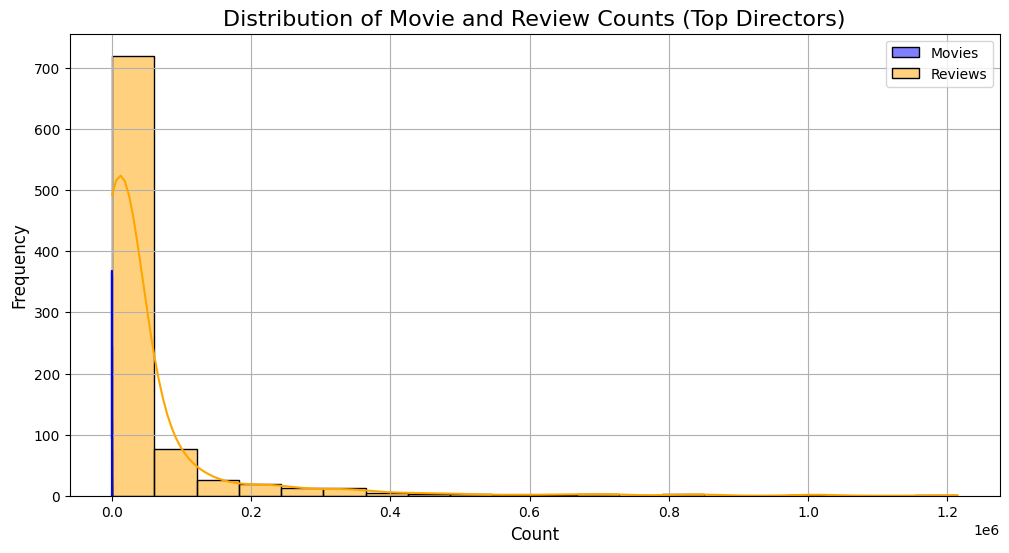

In [8]:
# 상위 감독의 영화 수와 리뷰 수 분포
plt.figure(figsize=(12, 6))
sns.histplot(top_directors["movie_count"], kde=True, bins=20, color="blue", label="Movies")
sns.histplot(top_directors["review_count"], kde=True, bins=20, color="orange", label="Reviews")
plt.title("Distribution of Movie and Review Counts (Top Directors)", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

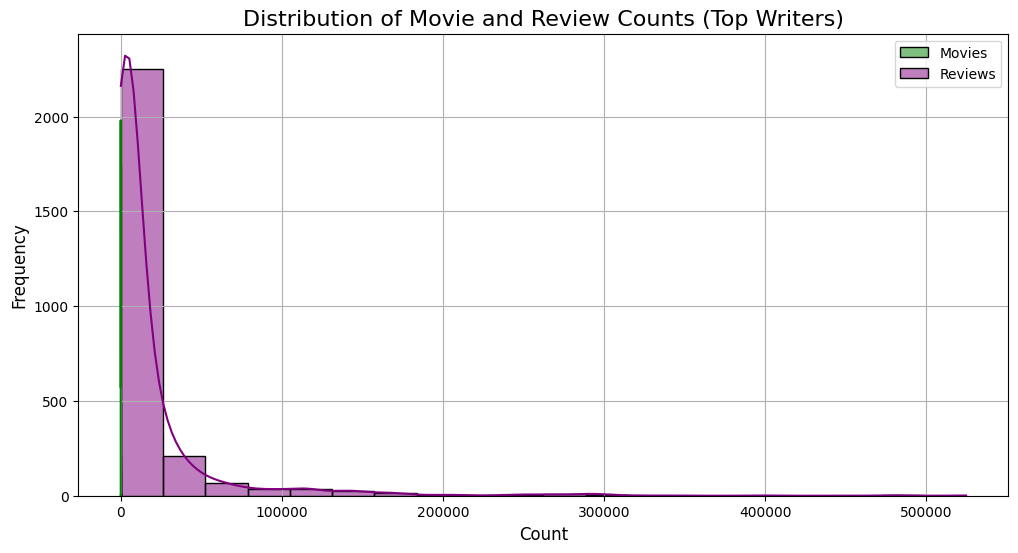

In [9]:
# 상위 작가의 영화 수와 리뷰 수 분포
plt.figure(figsize=(12, 6))
sns.histplot(top_writers["movie_count"], kde=True, bins=20, color="green", label="Movies")
sns.histplot(top_writers["review_count"], kde=True, bins=20, color="purple", label="Reviews")
plt.title("Distribution of Movie and Review Counts (Top Writers)", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# 원본 데이터에 상위 그룹 여부 추가
merged_df["is_top_director"] = merged_df["director"].isin(top_directors["director"])
merged_df["is_top_writer"] = merged_df["writer"].isin(top_writers["writer"])

In [11]:
# 상위 그룹과 나머지 그룹의 리뷰 수 비교
top_group_reviews = merged_df[merged_df["is_top_director"] | merged_df["is_top_writer"]]["user"].count()
other_group_reviews = merged_df[~(merged_df["is_top_director"] | merged_df["is_top_writer"])]["user"].count()

In [12]:
print(f"Top Group Reviews: {top_group_reviews}")
print(f"Other Group Reviews: {other_group_reviews}")

Top Group Reviews: 47543681
Other Group Reviews: 720650


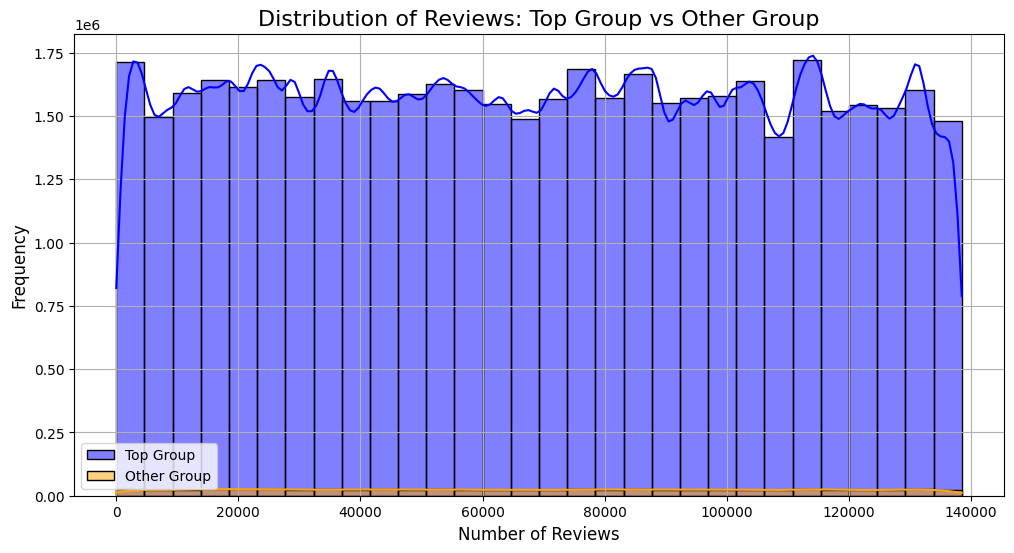

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(merged_df[merged_df["is_top_director"] | merged_df["is_top_writer"]]["user"], kde=True, bins=30, color="blue", label="Top Group")
sns.histplot(merged_df[~(merged_df["is_top_director"] | merged_df["is_top_writer"])]["user"], kde=True, bins=30, color="orange", label="Other Group")
plt.title("Distribution of Reviews: Top Group vs Other Group", fontsize=16)
plt.xlabel("Number of Reviews", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#추가 분석: 평균 리뷰 수 비교
# 상위 그룹과 나머지 그룹의 리뷰 수 평균 비교
top_group_avg_reviews = merged_df[merged_df["is_top_director"]]["user"].mean()
other_group_avg_reviews = merged_df[~(merged_df["is_top_director"])]["user"].mean()

print(f"Average Reviews (Top Group): {top_group_avg_reviews}")
print(f"Average Reviews (Other Group): {other_group_avg_reviews}")

Average Reviews (Top Group): 68755.84300371849
Average Reviews (Other Group): 68597.78611600293


In [15]:
# t-검정: 상위 그룹과 나머지 그룹의 리뷰 수
top_group_reviews = merged_df[merged_df["is_top_director"] | merged_df["is_top_writer"]]["user"]
other_group_reviews = merged_df[~(merged_df["is_top_director"] | merged_df["is_top_writer"])]["user"]

t_stat, p_value = ttest_ind(top_group_reviews, other_group_reviews, equal_var=False)
print(f"T-Test: t={t_stat}, p={p_value}")
if p_value < 0.05:
    print("The difference between the groups is statistically significant.")
else:
    print("The difference between the groups is not statistically significant.")

T-Test: t=3.4886028348385065, p=0.00048558010898767484
The difference between the groups is statistically significant.
